In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import yaml

sys.path.append("../")

%load_ext autoreload
%autoreload 2

In [9]:
from preprocessing.utils import get_train_test_data
from model.hierarchical_self_attention_model import HSA_model_session_guided_window

In [10]:
hyperparameters = yaml.load(open('../configs/metadata.yaml', mode='r'), Loader=yaml.FullLoader)

metadata_file = open('../configs/metadata.yaml', mode='r')

In [15]:
(X_train, y_train), (X_test, y_test) = get_train_test_data(dataset='pamap2', holdout=False)

../../data/HAR/raw/PAMAP2_Dataset/Protocol
../../data/HAR/raw/PAMAP2_Dataset/Protocol
../../data/HAR/raw/PAMAP2_Dataset/Protocol
Done.


In [16]:
print(X_train.shape)
print(y_train.shape)

(3154, 15, 100, 18)
(3154, 19)


In [25]:
# mid_labels = np.repeat(np.expand_dims(y_train, axis=1), repeats=15, axis=1)

In [26]:
# mid_labels[0]

In [27]:
y_train_mid = np.repeat(np.expand_dims(y_train, axis=1), repeats=15, axis=1)
y_test_mid = np.repeat(np.expand_dims(y_test, axis=1), repeats=15, axis=1)

In [34]:
y_test_mid.shape

(468, 15, 19)

In [36]:
hparam_file = open('../configs/hyperparameters.yaml', mode='r')
hyperparameters = yaml.load(hparam_file, Loader=yaml.FullLoader)
hparams = hyperparameters['HSA_model']
hparams['modality_indices'] = hparams['modality_indices']['pamap2']
hparams['n_window'], hparams['n_timesteps'], hparams['n_features'], hparams['n_outputs'] = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]
hparams['n_outputs_window']=19

## Training

In [47]:
tf.keras.backend.clear_session()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
device_list = ['/gpu:'+str(i) for i in range(5, 8)]
strategy = tf.distribute.MirroredStrategy(devices=device_list)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    model = HSA_model_session_guided_window(**hyperparameters['HSA_model']).get_compiled_model()

8 Physical GPUs, 8 Logical GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
Number of devices: 3


In [48]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 100, 18) 0                                            
__________________________________________________________________________________________________
multi_window_encoder (MultiWind ((None, None, 64), ( 350720      input_1[0][0]                    
__________________________________________________________________________________________________
modality_encoder_block_3 (Modal (None, None, 64)     104000      multi_window_encoder[0][0]       
__________________________________________________________________________________________________
combined_sensor_self_attention_ ((None, 64), (None,  49856       modality_encoder_block_3[0][0]   
____________________________________________________________________________________________

In [49]:
model.fit(X_train, [y_train_mid, y_train], batch_size=len(device_list) * 64, epochs=40, validation_split=0.1, use_multiprocessing=True)

Epoch 1/40
INFO:tensorflow:batch_all_reduce: 160 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 160 all-reduces with algorithm = nccl, num_packs = 1
15/15 [==============================] - 19s 1s/step - loss: 5.4424 - session_pred_accuracy: 0.1071 - window_pred_accuracy: 0.1183 - window_pred_loss: 2.6673 - session_pred_loss: 2.7751 - val_loss: 5.3977 - val_session_pred_accuracy: 0.0506 - val_window_pred_accuracy: 0.0000e+00 - val_window_pred_loss: 2.6935 - val_session_pred_loss: 2.7042
Epoch 2/40
15/15 [==============================] - 11s 712ms/step - loss: 4.9303 - session_pred_accuracy: 0.1092 - window_pred_accuracy: 0.1675 - window_pred_loss: 2.3928 - session_pred_loss: 2.5375 - val_loss: 5.0743 - val_session_pred_accuracy: 0.0000e+00 - val_window_pred_accuracy: 0.1871 - val_window_pred_loss: 2.4650 - val_session_pred_loss: 2.6093
Epoch 3/40
15/15 [==============================] - 11s 713ms/step - loss: 4.1391 - session_pred_accuracy: 0.1998 -

In [50]:
pred_mid, pred_sess = model.predict(X_test, batch_size=len(device_list) * 64)

In [51]:
labels_map = {1:'lying',2:'sitting',3:'standing',4:'walking',5:'running',6:'cycling',7:'Nordic walking',
              11:'ascending stairs',12:'descending stairs',13:'vacuum cleaning',
              14:'ironing', 18:'rope jumping'}
class_names = list(labels_map.values())

In [52]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1), labels = list(labels_map.keys()), target_names=class_names, zero_division=1))

                   precision    recall  f1-score   support

            lying       1.00      1.00      1.00        44
          sitting       0.86      1.00      0.93        44
         standing       0.97      0.85      0.91        46
          walking       1.00      0.98      0.99        49
          running       1.00      1.00      1.00        43
          cycling       1.00      1.00      1.00        38
   Nordic walking       1.00      1.00      1.00        51
 ascending stairs       1.00      1.00      1.00        22
descending stairs       1.00      1.00      1.00        18
  vacuum cleaning       1.00      1.00      1.00        40
          ironing       1.00      1.00      1.00        73
     rope jumping       1.00      1.00      1.00         0

        micro avg       0.98      0.98      0.98       468
        macro avg       0.99      0.99      0.99       468
     weighted avg       0.98      0.98      0.98       468



In [43]:
import json
import os
activity_map = json.load(open(os.path.join('..','data', 'activity_maps', 'pamap2_activity.json')))

In [44]:
activity_map

{'1': 'lying',
 '2': 'sitting',
 '3': 'standing',
 '4': 'walking',
 '5': 'running',
 '6': 'cycling',
 '7': 'Nordic walking',
 '11': 'ascending stairs',
 '12': 'descending stairs',
 '13': 'vacuum cleaning',
 '14': 'ironing',
 '18': 'rope jumping'}

<AxesSubplot:>

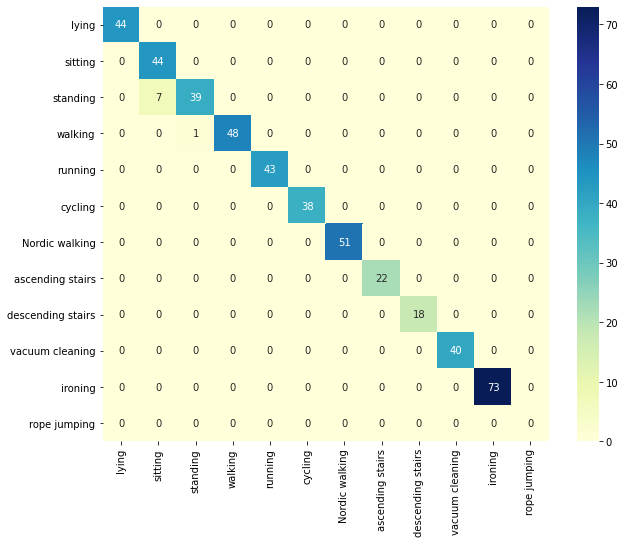

In [58]:
confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1), labels = list(labels_map.keys()))
activity_list = list(activity_map.values())
df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

In [56]:
print(classification_report(np.argmax(y_test_mid.reshape(-1, 19), axis=1), np.argmax(pred_mid.reshape(-1, 19), axis=1),labels = list(labels_map.keys()), target_names=class_names, zero_division=1))

                   precision    recall  f1-score   support

            lying       1.00      1.00      1.00       660
          sitting       0.86      1.00      0.93       660
         standing       0.98      0.85      0.91       690
          walking       0.99      0.99      0.99       735
          running       1.00      0.99      1.00       645
          cycling       1.00      1.00      1.00       570
   Nordic walking       1.00      1.00      1.00       765
 ascending stairs       1.00      1.00      1.00       330
descending stairs       1.00      1.00      1.00       270
  vacuum cleaning       1.00      1.00      1.00       600
          ironing       1.00      1.00      1.00      1095
     rope jumping       1.00      1.00      1.00         0

        micro avg       0.98      0.98      0.98      7020
        macro avg       0.99      0.99      0.98      7020
     weighted avg       0.98      0.98      0.98      7020

